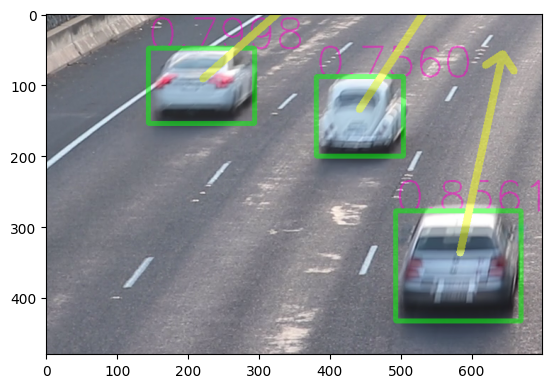

In [60]:
import pickle
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from mcf.data_types import Frame
from mcf.data_types import DetectionRegion
from mcf.common import get_center_of_mass

GREEN = (0,255,0)
RED = (0,0,255)
PURPLE = (200, 0, 256)
BLUE = (255,0,0)

with open("./data/current_frame.pickle", "rb") as f:
    current_frame: Frame = pickle.load(f)

with open("./data/last_frame.pickle", "rb") as f:
    last_frame: Frame = pickle.load(f)

def add_bounding_box(image: np.array, bounding_box: tuple[tuple[int,int],tuple[int,int]], color):
    top_left, bottom_right = bounding_box
    # add bounding box
    cv.rectangle(image, top_left, bottom_right, color, 1)

alpha = 0.5
blended_image = cv.addWeighted(last_frame.image, alpha, current_frame.image, 1 - alpha, 0)
plt.imshow(blended_image[600:,600:1300,::-1])

In [77]:
def motion_prediction(detection_regions: list[DetectionRegion]):
    """ predict next locations from last_detection_regions """

    """ update last detection regions w/ prediction """

    """ linear model: x0 + V t """
    """ we could use a quadratic model by recording the preceding detection regions velocities -> delta of velocity would give acceleration """

    for detection_region in detection_regions:
        velocities = detection_region.velocities
        filter_coeffs = make_filter(len(velocities))
        translation_vector = prediction_model(velocities, filter_coeffs)
        detection_region.next_center_of_mass = predict_center_of_mass(detection_region.center_of_mass, translation_vector)
        detection_region.next_bounding_box = predict_bounding_box(detection_region.bounding_box, translation_vector)
    return

def make_filter(size):
    filter_coeffs = []
    for n in range(size):
        filter_coeffs.append(np.exp(-n*0.8))
    filter_coeffs /= np.sum(filter_coeffs)
    return filter_coeffs

# returns the (y, x) translation factors from the prediction model
def prediction_model(velocities, filter_coeffs):
    Vy,Vx = 0,0
    
    N = min(len(velocities), len(filter_coeffs))
    for idx in range(N):
        Vy += filter_coeffs[idx] * velocities[idx][0]
        Vx += filter_coeffs[idx] * velocities[idx][1]
        
    Vy = int(np.round(Vy))
    Vx = int(np.round(Vx))
    dy,dx = Vy,Vx
    return dy,dx

def predict_center_of_mass(center_of_mass, translation_vector):
    dy, dx = translation_vector
    predicted_center_of_mass = (center_of_mass[0] + dy,
                                center_of_mass[1] + dx)
    return predicted_center_of_mass

def predict_bounding_box(bounding_box, translation_vector):
    dy, dx = translation_vector
    predicted_bounding_box = ((bounding_box[0][0] + dx, 
                               bounding_box[0][1] + dy),
                              (bounding_box[1][0] + dx, 
                               bounding_box[1][1] + dy))
    return predicted_bounding_box

Text(0.5, 1.0, 'current frame\nblue: last, red: predicted, green: measured')

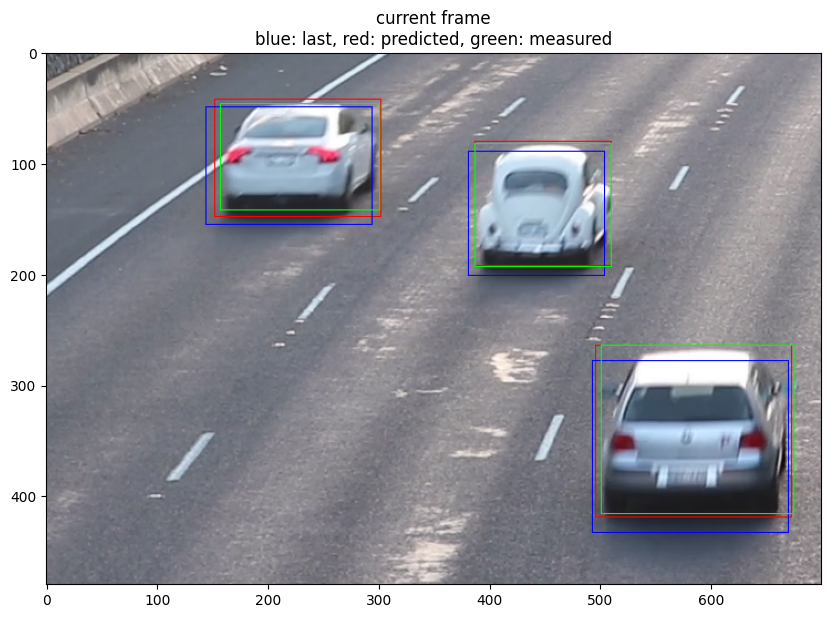

In [78]:

motion_prediction(last_frame.detection_regions)

image = current_frame.image.copy()
for detection_region in last_frame.detection_regions:
    add_bounding_box(image, detection_region.next_bounding_box, RED) # predicted location
    add_bounding_box(image, detection_region.bounding_box, BLUE) # old location
    
for detection_region in current_frame.detection_regions:
    add_bounding_box(image, detection_region.bounding_box, GREEN) # measured location


plt.figure(figsize=(10,10))
plt.imshow(image[600:,600:1300,::-1])
plt.title('current frame\nblue: last, red: predicted, green: measured')

standard devation y: 1.283133813130961
standard devation x: 1.2901130592316319


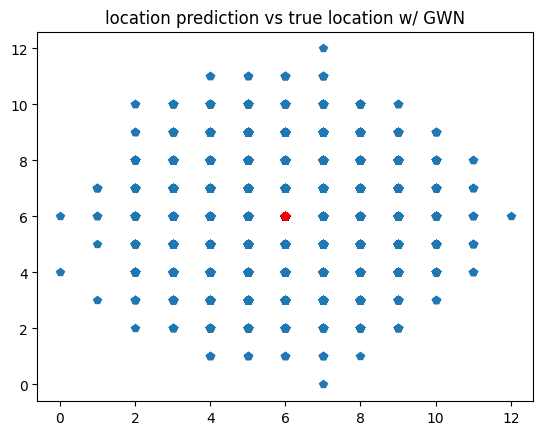

In [79]:
def test_case():
    detection_region = DetectionRegion(classification=1,
                                       confidence=1.0,
                                       bounding_box=((0,0),(2,2)),
                                       mask=None,
                                       center_of_mass=(1,1)
                                       )
    detection_region.velocities = []
    velocity = (5.0, 5.0)
    for _ in range(5):
        v = ((velocity[0] + np.random.normal(0,2)), (velocity[1] + np.random.normal(0,2)))
        detection_region.velocities.append(v)

    motion_prediction([detection_region])

    true_loc = (detection_region.center_of_mass[0] + velocity[0], detection_region.center_of_mass[1] + velocity[1])
    observed_loc = detection_region.next_center_of_mass
    return true_loc, observed_loc

number_of_trials = 100000
true_locations_y = []
true_locations_x = []
observed_locations_y = []
observed_locations_x = []

for _ in range(number_of_trials):
    true_loc, observed_loc = test_case()
    true_locations_y.append(true_loc[0])
    true_locations_x.append(true_loc[1])
    observed_locations_y.append(observed_loc[0])
    observed_locations_x.append(observed_loc[1])

plt.figure()
plt.plot(observed_locations_x, observed_locations_y, 'p')
plt.plot(true_locations_x, true_locations_y, 'pr')
plt.title('location prediction vs true location w/ GWN')

print(f'standard devation y: {np.std(observed_locations_y)}')
print(f'standard devation x: {np.std(observed_locations_x)}')